# Modelos baseados em arvores para a modelagem do sistema
___

Essa ideia visa em facilitar o processo de treinamento, atualização e modelagem do sistema hidraulico do LENHS que será utilizado em conjunto com um sistema de controle Fuzzy.

In [1]:
!$PWD

/bin/bash: linha 1: /home/enacom/Documentos/github/smart-automation/ava02/pt2: É um diretório


## Bibliotecas

In [1]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import sys
try:
    sys.path.append('/home/enacom/Documentos/github/smart-automation/utils')
    # sys.path.append(r'C:\Users\ra-no\OneDrive\Documentos\GitHub\smart-automation\utils')
    from get_metrics import get_metrics, gera_metricas
    from create_figures import difference_plot
    for path in sys.path: print(path) 
except Exception as e:
    print(e)
    print('Import error')

/home/enacom/Documentos/github/smart-automation/ava02/pt2
/home/enacom/miniconda3/envs/ava02AutomacaoInt/lib/python312.zip
/home/enacom/miniconda3/envs/ava02AutomacaoInt/lib/python3.12
/home/enacom/miniconda3/envs/ava02AutomacaoInt/lib/python3.12/lib-dynload

/home/enacom/miniconda3/envs/ava02AutomacaoInt/lib/python3.12/site-packages
/home/enacom/Documentos/github/smart-automation/utils


## Dados de teste e treinamento

In [2]:
train_data = pd.read_csv('data/1s/train_data.csv')
test_data = pd.read_csv('data/1s/test_data.csv')

In [3]:
train_data.describe()

,Frequencia CMB,CV-1,PT-2,PT-2(K-1),PT-2(K-2)
count,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000
mean,45.040219,37.282171,12.398863,12.383641,12.371260
std,10.748762,26.316466,6.153182,6.146719,6.139553
min,30.000000,-0.467844,4.028348,4.028348,4.028348
25%,35.000000,7.113086,8.045247,8.044531,8.044433
50%,50.000000,29.603125,10.143024,10.141611,10.140514
75%,55.000000,59.645833,16.151530,16.148763,16.145709
max,60.000000,69.691667,26.229167,26.229167,26.229167


In [4]:
test_data.describe()

,Frequencia CMB,CV-1,PT-2,PT-2(K-1),PT-2(K-2)
count,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000
mean,45.954253,37.412160,12.681521,12.674583,12.667774
std,8.349046,26.670795,5.211418,5.207856,5.203526
min,33.000000,-0.509761,5.545885,5.545885,5.545885
25%,38.000000,5.150644,8.855039,8.854902,8.854902
50%,48.000000,30.680729,11.591276,11.590820,11.589974
75%,53.000000,59.629166,15.831901,15.746224,15.612500
max,58.000000,69.700000,24.719792,24.719792,24.719792


### Correlacao de Pearson para os dados de treinamento

In [3]:
corr_train = train_data.corr()

In [5]:
corr_train.filter(items=['PT-2']).sort_values(by='PT-2', ascending=False).T

,PT-2,PT-2(K-1),PT-2(K-2),Frequencia CMB,CV-1
PT-2,1.0,0.999825,0.999185,0.741287,0.639016


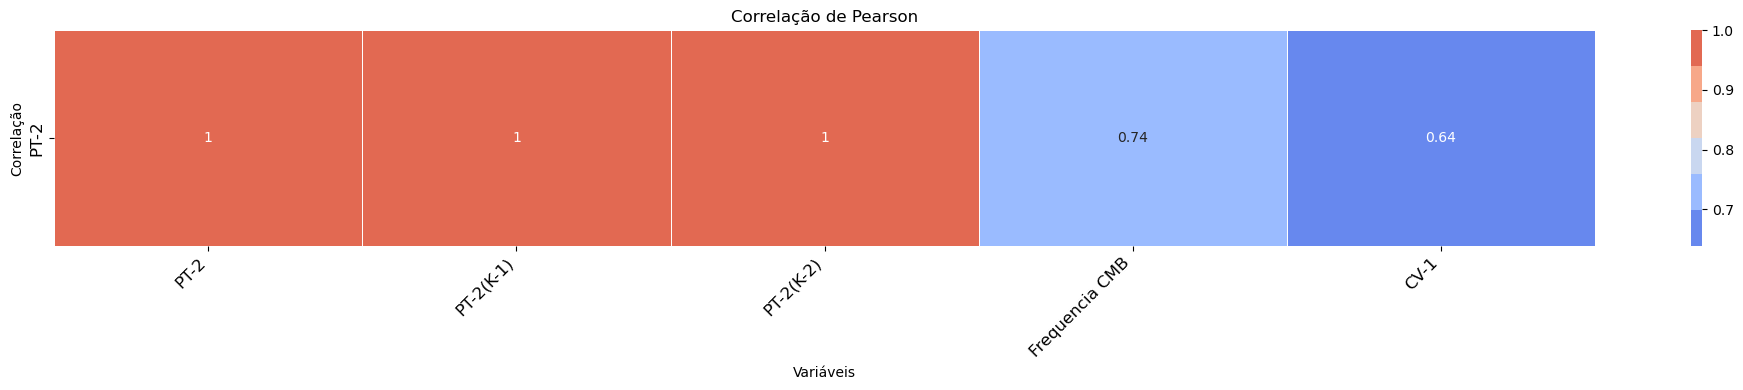

In [6]:
f, ax = plt.subplots(figsize=(20,4))

my_plot = sns.heatmap(
    # corr_train,
    corr_train.filter(items=['PT-2']).sort_values(by='PT-2', ascending=False).T,
    cmap=sns.color_palette("coolwarm"),
    linewidths=0.5,
    annot=True
)

my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)

#modify individual font size of elements
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Variáveis')
plt.ylabel('Correlação')
plt.title('Correlação de Pearson')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(
    './images/correlacao_treinamento.pdf',
    format='pdf',
    dpi=300
)

In [7]:
train_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frequencia CMB  3108 non-null   float64
 1   CV-1            3108 non-null   float64
 2   PT-2            3108 non-null   float64
 3   PT-2(K-1)       3108 non-null   float64
 4   PT-2(K-2)       3108 non-null   float64
dtypes: float64(5)
memory usage: 121.5 KB


In [8]:
test_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3104 entries, 0 to 3103
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frequencia CMB  3104 non-null   float64
 1   CV-1            3104 non-null   float64
 2   PT-2            3104 non-null   float64
 3   PT-2(K-1)       3104 non-null   float64
 4   PT-2(K-2)       3104 non-null   float64
dtypes: float64(5)
memory usage: 121.4 KB


In [18]:
train_data.columns

Index(['Frequencia CMB', 'CV-1', 'PT-2', 'PT-2(K-1)', 'PT-2(K-2)'], dtype='object')

In [27]:
x_train, y_train = train_data[['Frequencia CMB', 'CV-1', 'PT-2(K-1)', 'PT-2(K-2)']], train_data[['PT-2']]
x_test, y_test = test_data[['Frequencia CMB', 'CV-1', 'PT-2(K-1)', 'PT-2(K-2)']], test_data[['PT-2']]
# train_test_split(
#     data[['Frequencia CMB', 'CV-1']],
#     data[['PT-2'']],
#     test_size=0.3,
#     random_state=812,
#     shuffle=False
# )

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (3108, 4)
x_test shape: (3104, 4)
y_train shape: (3108, 1)
y_test shape: (3104, 1)


In [28]:
test_data['Frequencia CMB'].unique()

array([53., 52., 51., 49., 48., 46., 44., 42., 38., 37., 36., 34., 33.,
       39., 41., 43., 58.])

In [29]:
train_data['Frequencia CMB'].unique()

array([40., 30., 35., 45., 50., 55., 60.])

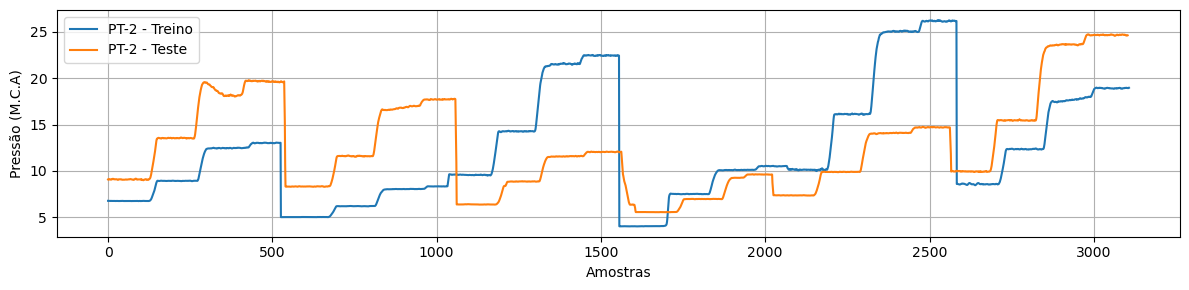

In [33]:
plt.figure(figsize=(12, 3))
plt.plot(y_train['PT-2'], label='PT-2 - Treino')

plt.plot(y_test['PT-2'], label='PT-2 - Teste')
plt.grid()
plt.legend()
plt.xlabel('Amostras')
plt.ylabel('Pressão (M.C.A)')

plt.tight_layout()

plt.savefig(
    './images/pt2_saida_teste_treino.png',
    format='png',
    dpi=300
)

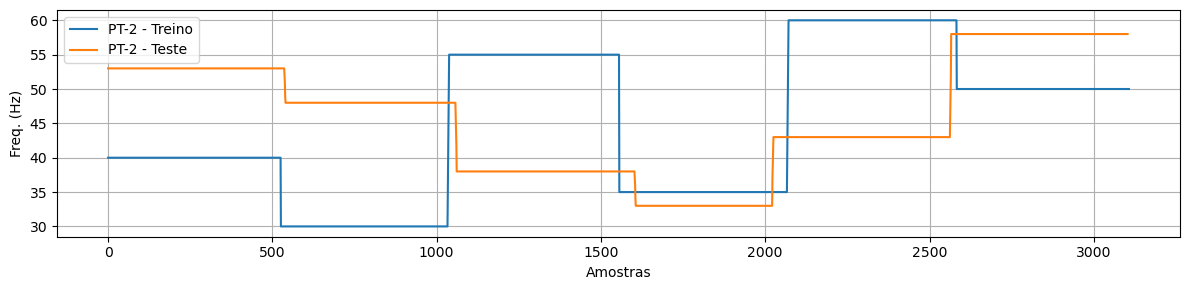

In [34]:
plt.figure(figsize=(12, 3))
plt.plot(x_train['Frequencia CMB'], label='PT-2 - Treino')

plt.plot(x_test['Frequencia CMB'], label='PT-2 - Teste')
plt.grid()
plt.legend()
plt.xlabel('Amostras')
plt.ylabel('Freq. (Hz)')
plt.tight_layout()

plt.savefig(
    './images/freq_saida_teste_treino.png',
    format='png',
    dpi=300
)

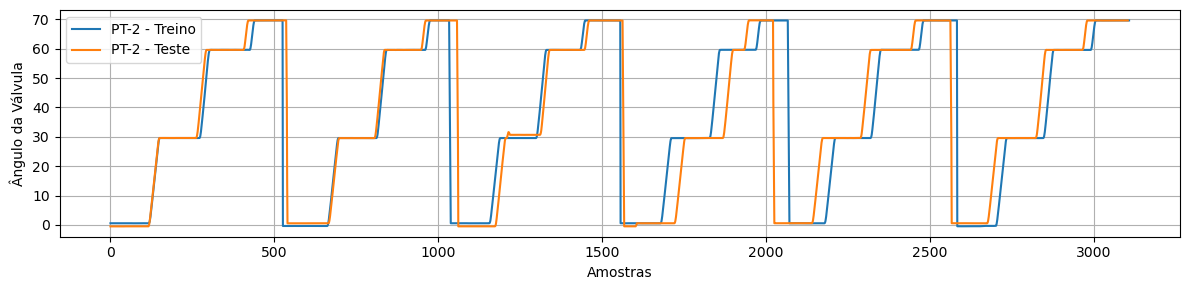

In [35]:
plt.figure(figsize=(12, 3))
plt.plot(x_train[ 'CV-1'], label='PT-2 - Treino')

plt.plot(x_test[ 'CV-1'], label='PT-2 - Teste')
plt.grid()
plt.legend()
plt.xlabel('Amostras')
plt.ylabel('Ângulo da Válvula')
plt.tight_layout()

plt.savefig(
    './images/cv1_saida_teste_treino.png',
    format='png',
    dpi=300
)

## Decision Tree Model

In [47]:
dt_model = DecisionTreeRegressor(
    max_depth=5,
    # random_state=812,
)
dt_model

DecisionTreeRegressor(max_depth=5)

In [48]:
start = time()
dt_model.fit(
    x_train,
    y_train
)
print(f'Tempo de treinamento: {time() - start}')

Tempo de treinamento: 0.0066335201263427734


In [49]:
dt_model.score(x_test, y_test)

0.9918282907378321

In [50]:
predicted = dt_model.predict(x_test)
predicted

array([ 8.7668655 ,  8.7668655 ,  9.57554672, ..., 25.01712866,
       25.01712866, 25.01712866])

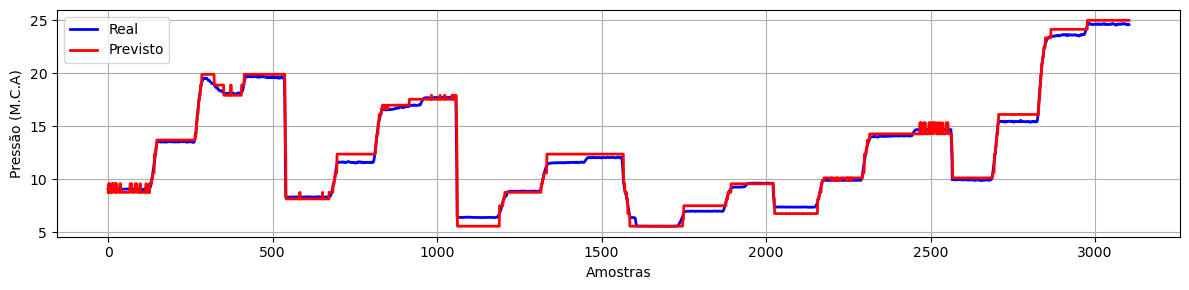

In [51]:
plt.figure(figsize=(12, 3))
plt.plot(y_test['PT-2'].values, label='Real', linewidth=2, color='blue')
plt.plot(predicted, label='Previsto', linewidth=2, color='red')
plt.xlabel('Amostras')
plt.ylabel('Pressão (M.C.A)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(
    './images/tree_results/sklearn_model.png',
    format='png',
    dpi=300
)

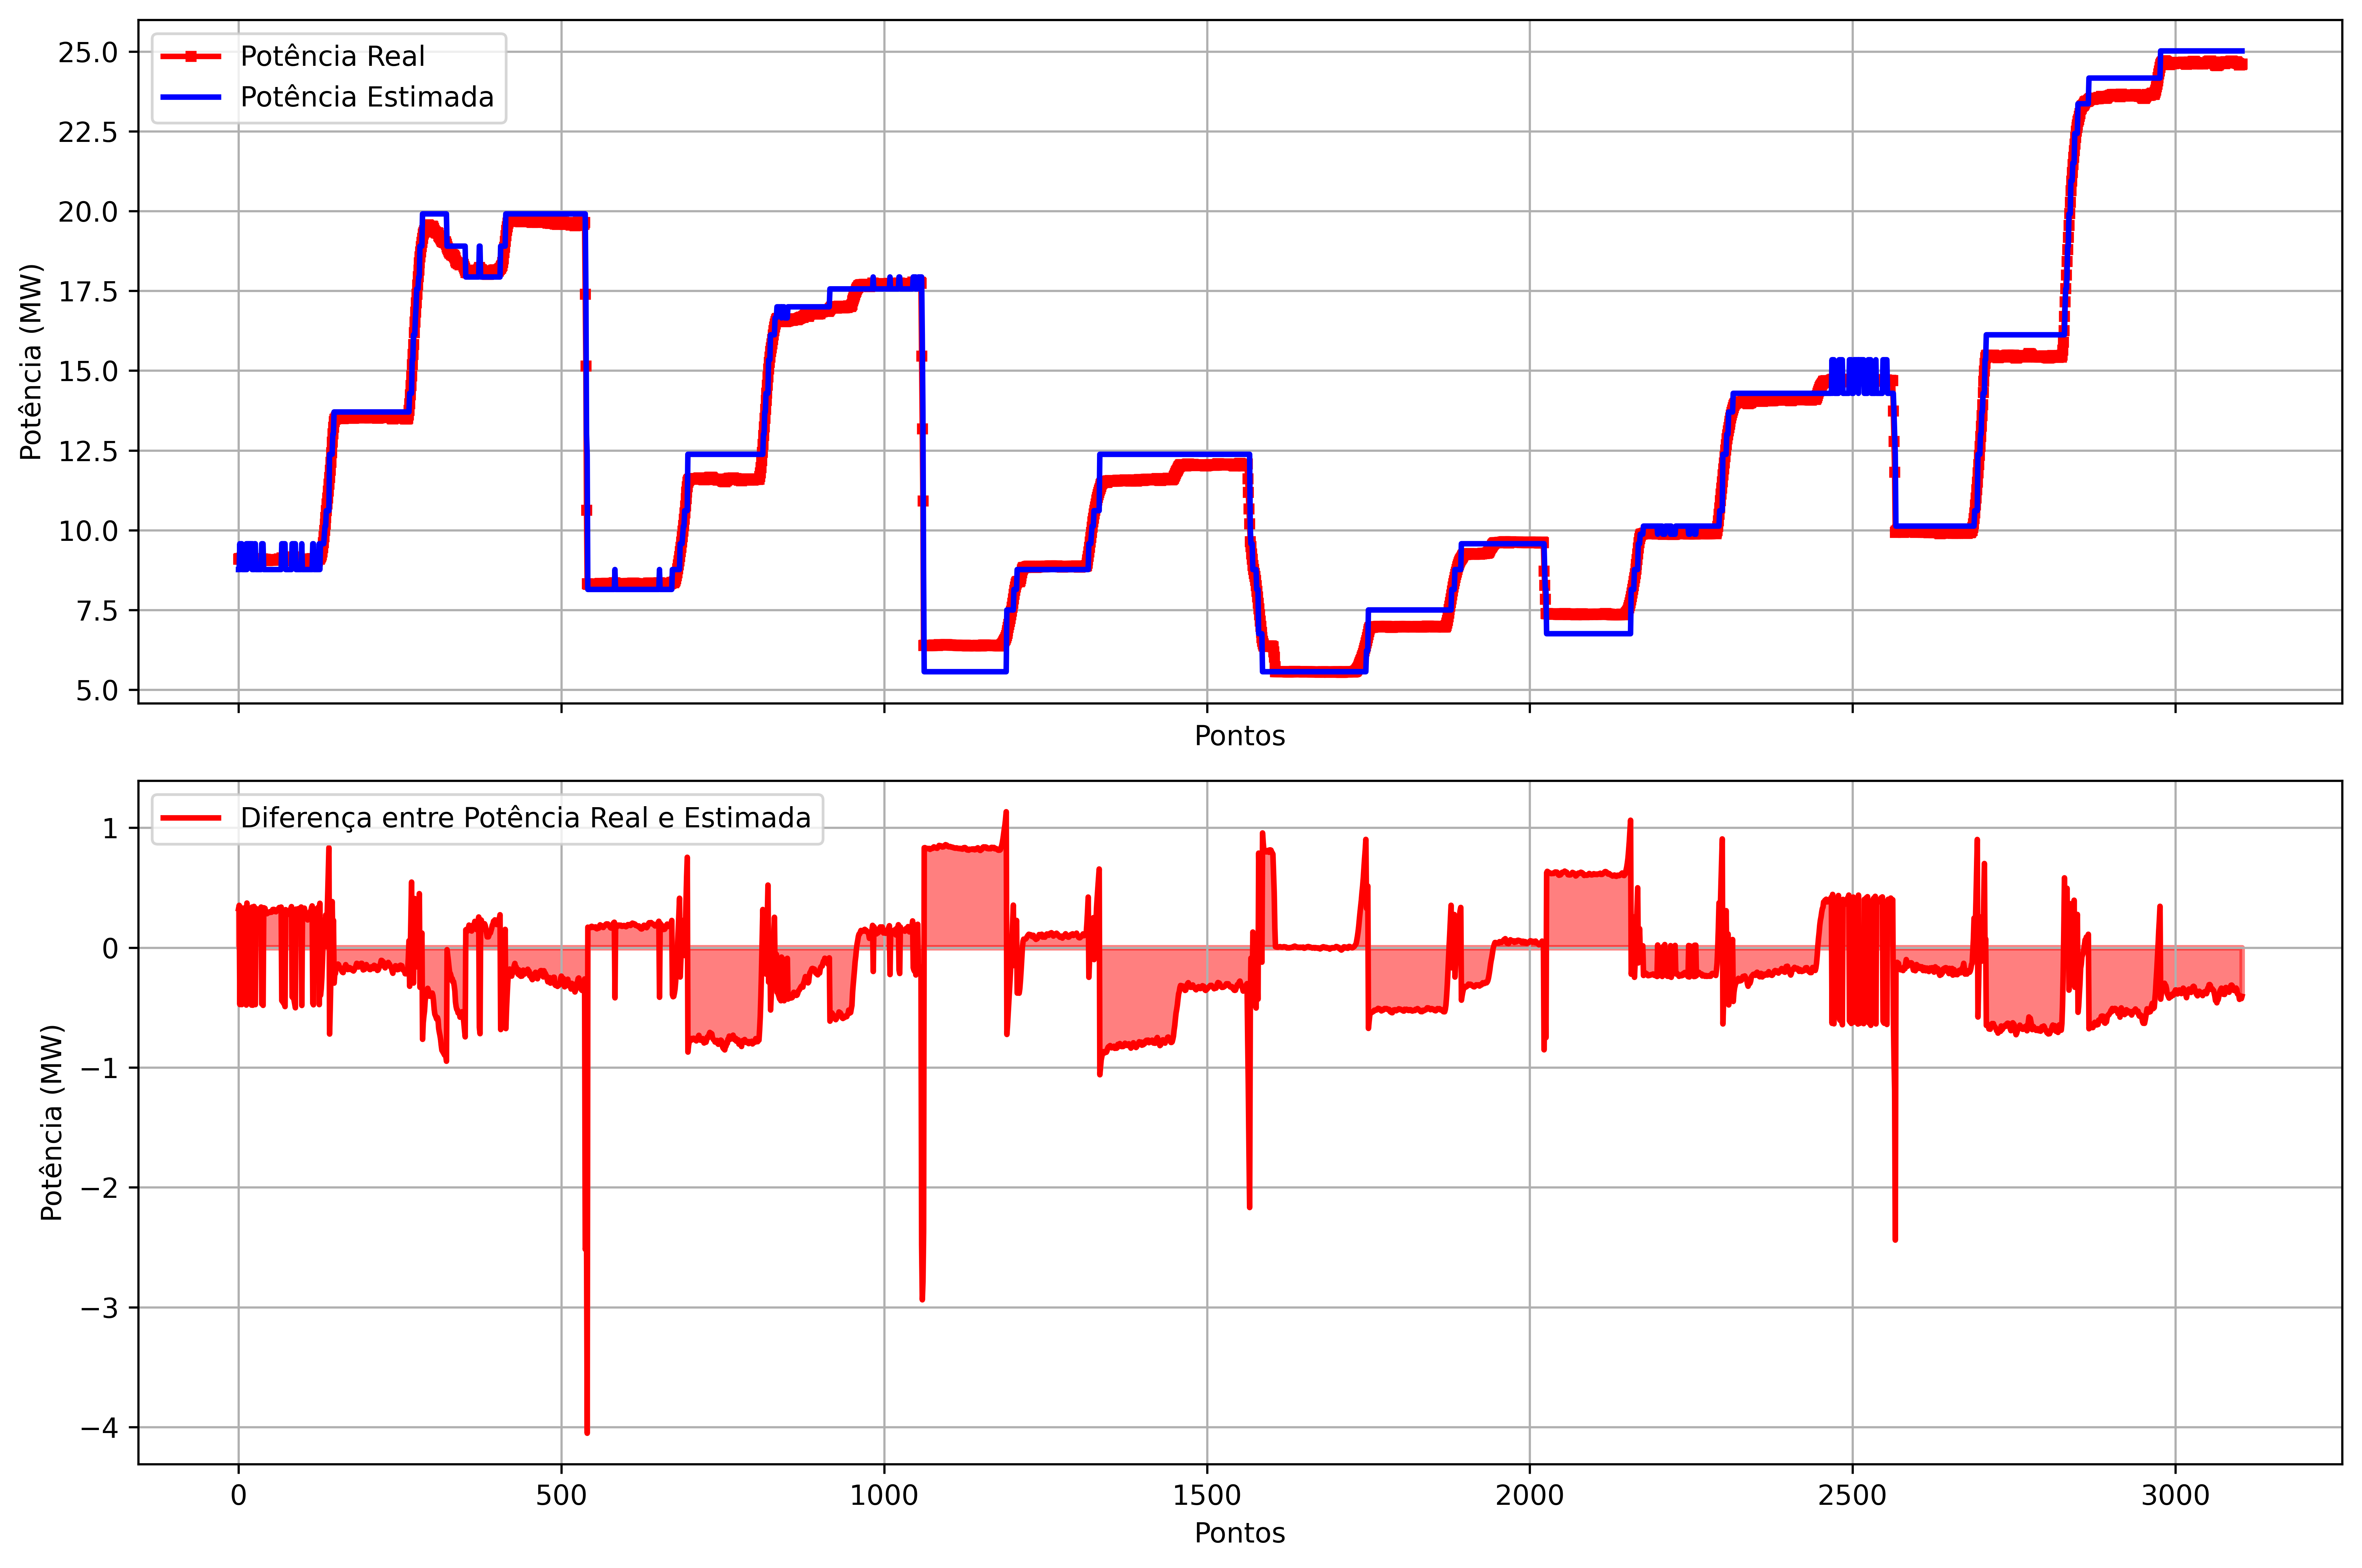

In [63]:
difference_plot(
    df_metricas['PT-2'].values,
    df_metricas['pt2_pred_dt'].values
)

### Feature importance

In [53]:
for column, importance in zip(x_train.columns, dt_model.feature_importances_):
    print(f'{column}: {importance}')
# dt_model.feature_importances_

Frequencia CMB: 0.0
CV-1: 0.0003698168721720412
PT-2(K-1): 0.9812223663534053
PT-2(K-2): 0.018407816774422582


[Text(0.5, 0.9166666666666666, 'PT-2(K-1) <= 14.71\nsquared_error = 37.849\nsamples = 3108\nvalue = 12.399'),
 Text(0.25, 0.75, 'PT-2(K-1) <= 9.101\nsquared_error = 7.765\nsamples = 2229\nvalue = 9.022'),
 Text(0.125, 0.5833333333333334, 'PT-2(K-1) <= 6.65\nsquared_error = 2.603\nsamples = 1209\nvalue = 6.927'),
 Text(0.0625, 0.4166666666666667, 'PT-2(K-1) <= 5.292\nsquared_error = 0.742\nsamples = 444\nvalue = 5.084'),
 Text(0.03125, 0.25, 'PT-2(K-1) <= 4.398\nsquared_error = 0.244\nsamples = 301\nvalue = 4.567'),
 Text(0.015625, 0.08333333333333333, 'squared_error = 0.002\nsamples = 145\nvalue = 4.057'),
 Text(0.046875, 0.08333333333333333, 'squared_error = 0.002\nsamples = 156\nvalue = 5.042'),
 Text(0.09375, 0.25, 'CV-1 <= 25.469\nsquared_error = 0.042\nsamples = 143\nvalue = 6.173'),
 Text(0.078125, 0.08333333333333333, 'squared_error = 0.053\nsamples = 11\nvalue = 5.566'),
 Text(0.109375, 0.08333333333333333, 'squared_error = 0.008\nsamples = 132\nvalue = 6.223'),
 Text(0.1875, 0

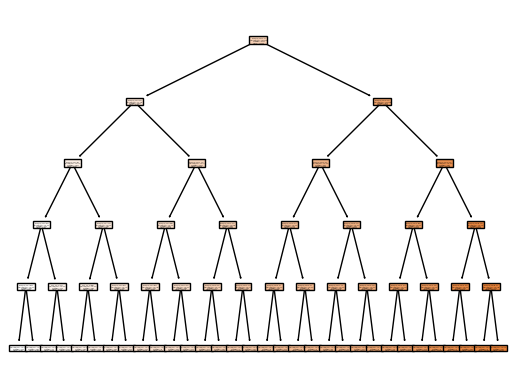

In [54]:
plot_tree(
    dt_model,
    filled=True,
    feature_names=x_train.columns,
    class_names=['PT-2'],
)

### Metricas

In [58]:
df_metricas = pd.DataFrame()
df_metricas = y_test.reset_index(drop=True).copy()
# df_metricas['pt1_pred_dt'] = predicted[:, 0]
df_metricas['pt2_pred_dt'] = predicted
# df_metricas['pt3_pred_dt'] = predicted[:, 2]

df_metricas.head()

,PT-2,pt2_pred_dt
0,9.091071,8.766865
1,9.119457,8.766865
2,9.100893,9.575547
3,9.105804,8.766865
4,9.126302,9.575547


In [59]:
get_metrics(
    df_metricas['PT-2'].values,
    df_metricas['pt2_pred_dt'].values
)

MAE: 0.3753
MSE: 0.2219
RMSE: 0.471
MAPE: 3.4994
ERPM: 48.6569


## CatBoost Model

In [124]:
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.01,
    depth=5,
    verbose=0,
)
cat_model

In [125]:
cat_model.fit(
    x_train,
    y_train
)

In [126]:
cat_model.score(x_test, y_test)

0.9957403641982219

In [127]:
cat_predicted = cat_model.predict(x_test)
cat_predicted

array([ 9.27158448,  9.27158448,  9.27158448, ..., 24.48834152,
       24.49358359, 24.49358359])

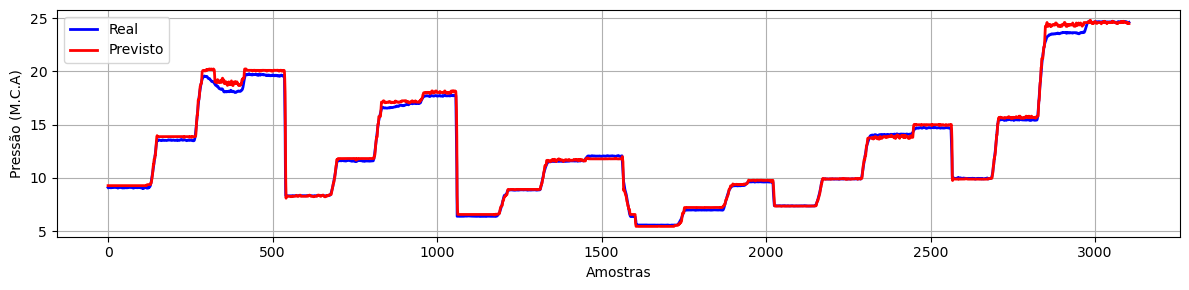

In [129]:
plt.figure(figsize=(12, 3))
plt.plot(y_test['PT-2'].values, label='Real', linewidth=2, color='blue')
plt.plot(cat_predicted, label='Previsto', linewidth=2, color='red')
plt.xlabel('Amostras')
plt.ylabel('Pressão (M.C.A)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(
    './images/tree_results/catboost_model.png',
    format='png',
    dpi=300
)

### Metricas

In [130]:
df_metricas['pt2_pred_cat'] = cat_model.predict(x_test)
df_metricas.head()

,PT-2,pt2_pred_dt,pt2_pred_cat
0,9.091071,8.766865,9.271584
1,9.119457,8.766865,9.271584
2,9.100893,9.575547,9.271584
3,9.105804,8.766865,9.271584
4,9.126302,9.575547,9.271584


In [131]:
get_metrics(
    df_metricas['PT-2'].values,
    df_metricas['pt2_pred_cat'].values
)

MAE: 0.2352
MSE: 0.1156
RMSE: 0.3401
MAPE: 1.7878
ERPM: 31.4057


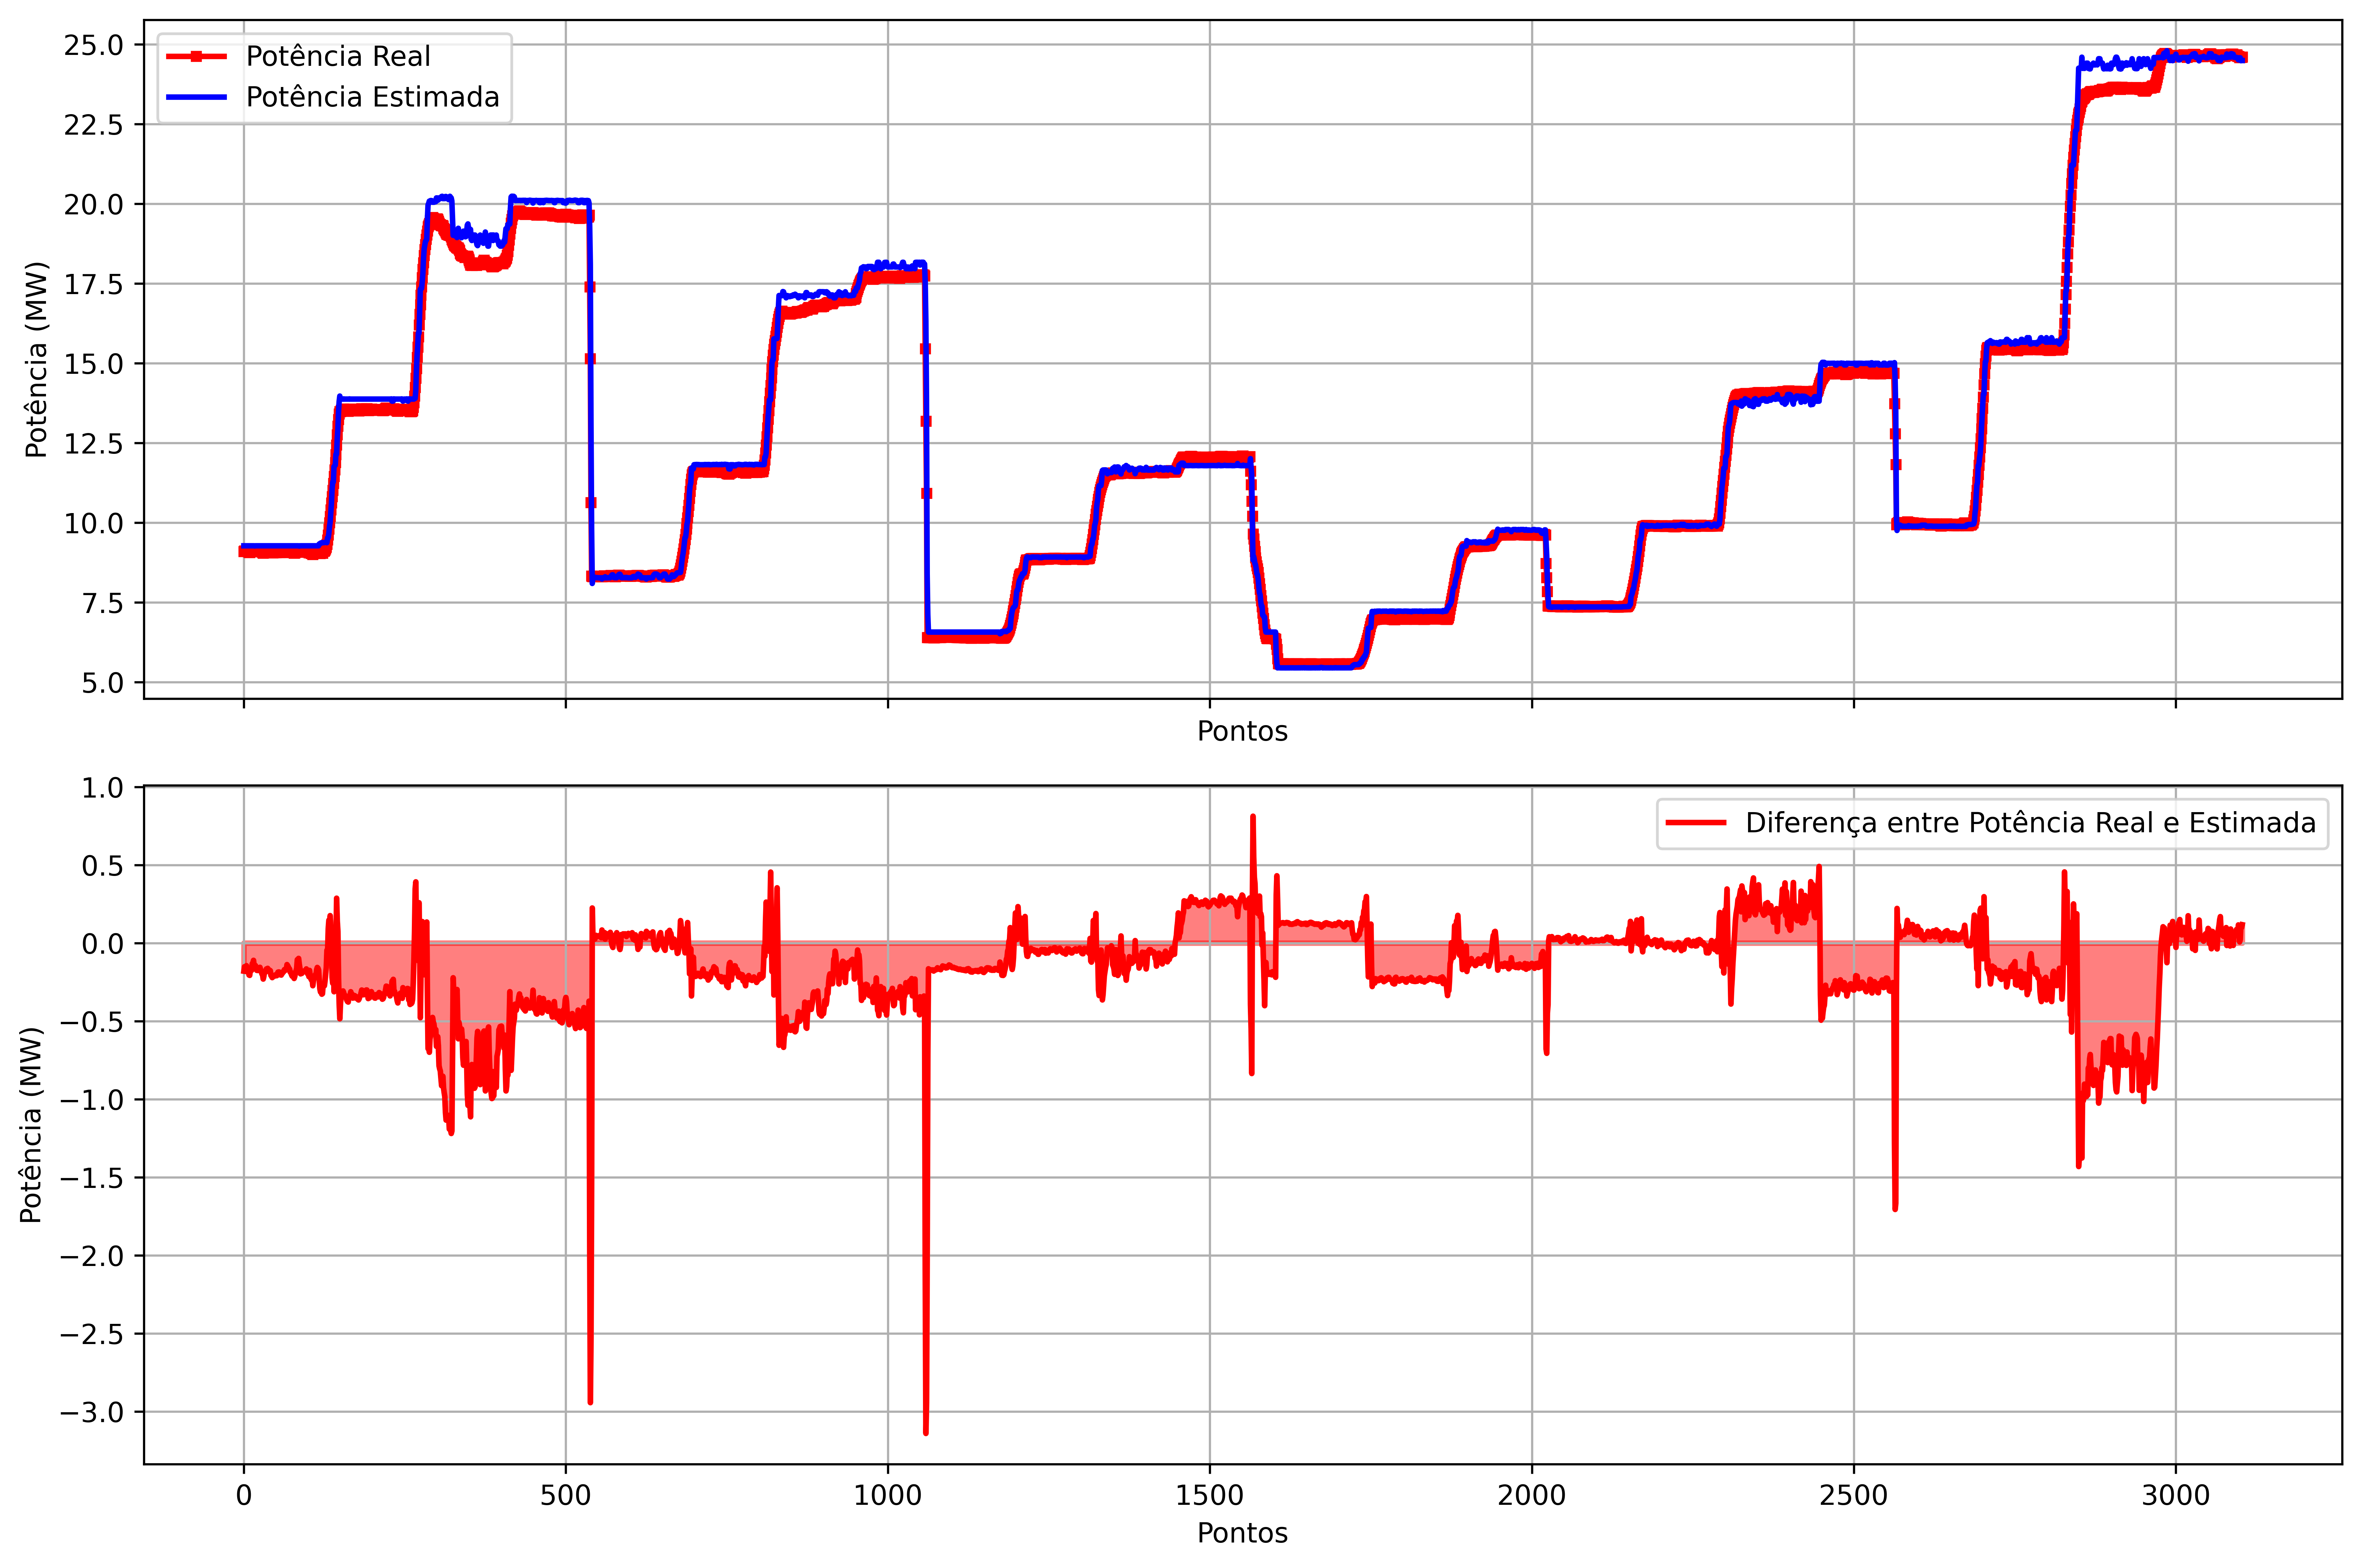

In [141]:
difference_plot(
    df_metricas['PT-2'].values,
    df_metricas['pt2_pred_cat'].values
)

### Feature importance

In [132]:
for col, value in zip(x_train.columns, cat_model.get_feature_importance()):
    print(f'{col}: {value}')

Frequencia CMB: 5.902361351168699
CV-1: 4.793544290014723
PT-2(K-1): 44.442587921148835
PT-2(K-2): 44.86150643766773


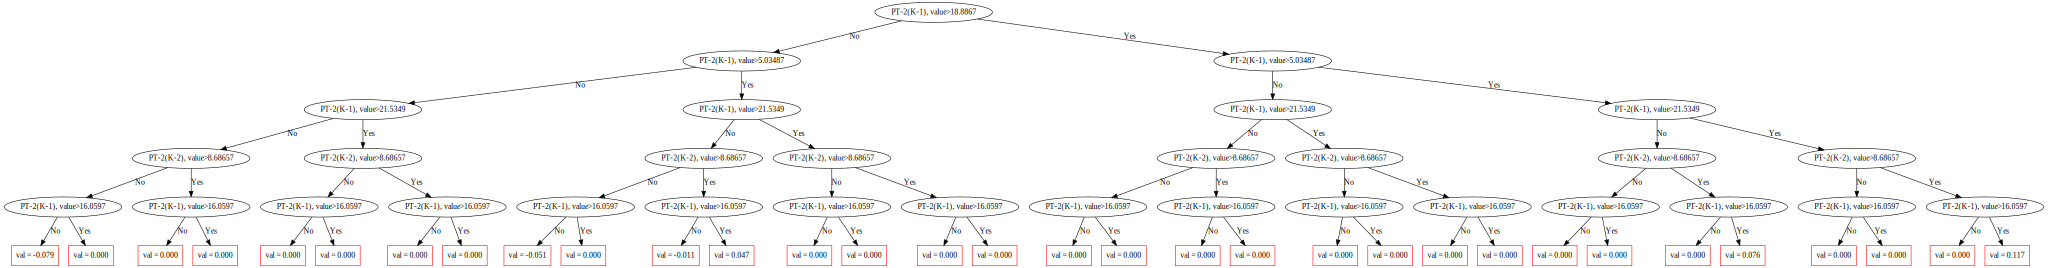

In [133]:
cat_model.plot_tree(
    tree_idx=0,
    pool=x_train,
)

In [134]:
cat_model.save_model('./models/cat_model_pt2.cbm')

In [135]:
df_metricas

,PT-2,pt2_pred_dt,pt2_pred_cat
0,9.091071,8.766865,9.271584
1,9.119457,8.766865,9.271584
2,9.100893,9.575547,9.271584
3,9.105804,8.766865,9.271584
4,9.126302,9.575547,9.271584
...,...,...,...
3099,24.585938,25.017129,24.579158
3100,24.601563,25.017129,24.579158
3101,24.596875,25.017129,24.488342
3102,24.592188,25.017129,24.493584


## Salvando valores reais e previstos

In [136]:
df_metricas.to_parquet('./models/tree_models_metrics.parquet')
df_metricas.to_csv('./models/tree_models_metrics.csv')

## Recarregando um modelo

In [137]:
start = time()
cat_model_reloaded = CatBoostRegressor()
cat_model_reloaded.load_model('./models/cat_model_pt2.cbm')

print(f'Tempo de carregamento: {time() - start}')

Tempo de carregamento: 0.003567218780517578


In [138]:
a = cat_model_reloaded.predict(x_test)
a

array([ 9.27158448,  9.27158448,  9.27158448, ..., 24.48834152,
       24.49358359, 24.49358359])

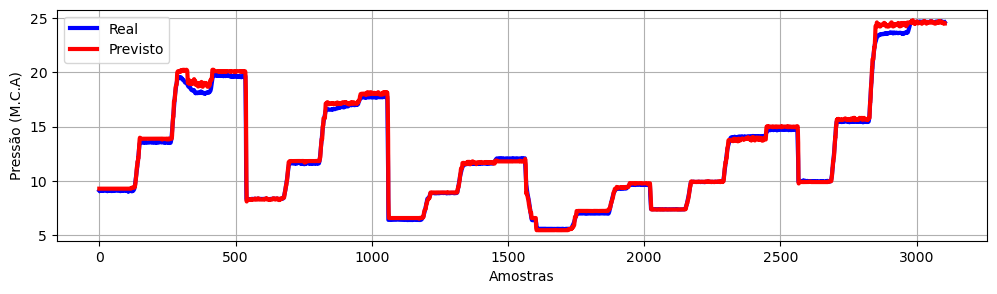

In [139]:
plt.figure(figsize=(12, 3))
plt.plot(y_test['PT-2'].values, label='Real', linewidth=3, color='blue')
plt.plot(cat_predicted, label='Previsto', linewidth=3, color='red')
plt.xlabel('Amostras')
plt.ylabel('Pressão (M.C.A)')
plt.legend()
plt.grid()

# plt.tight_layout()
# plt.savefig(
#     './images/tree_results/catboost_model.png',
#     format='png',
#     dpi=300
# )

In [140]:
get_metrics(
    y_test['PT-2'].values,
    a
)

MAE: 0.2352
MSE: 0.1156
RMSE: 0.3401
MAPE: 1.7878
ERPM: 31.4057
